In [43]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, explode, collect_list, avg, stddev, max, array, udf
from pyspark.sql.types import ArrayType, StringType, DateType, FloatType
from pyspark.sql.window import Window

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [44]:
spark = SparkSession.builder.appName("Time Series Binary Classification").getOrCreate()

In [45]:
df = spark.read.parquet("/content/train.parquet")
test_df = spark.read.parquet("/content/test.parquet")

In [287]:
df.show()
test_df.show()

+-----+--------------------+--------------------+-----+
|   id|               dates|              values|label|
+-----+--------------------+--------------------+-----+
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0|
|22769|[2016-05-01, 2016...|[-1.04, -3.48, 0....|  1.0|
|76935|[2017-03-01, 2017...|[0.28, 0.63, 0.06...|  0.0|
|66297|[2016-01-01, 2016...|[-0.33, 0.58, 1.1...|  0.0|
| 2191|[2016-01-01, 2016...|[1.31, 0.5, -0.54...|  0.0|
|59504|[2016-03-01, 2016...|[0.08, 0.88, 1.46...|  0.0|
|49554|[2016-04-01, 2016...|[1.05, -0.28, 1.0...|  0.0|
|58344|[2016-12-01, 2017...|[-0.36, -0.45, -0...|  0.0|
|87449|[2016-01-01, 2016...|[2.92, 4.11, 3.39...|  1.0|
|43415|[2016-02-01, 2016...|[-0.86, -0.05, -0...|  1.0|
|76676|[2016-01-01, 2016...|[2.24, 0.46, 1.41...|  0.0|
| 4321|[2016-01-01, 2016...|[1.1, 1.73, 2.04,...|  0.0|
|17921|[2016-01-01, 2016...|[1.06, 1.04, 0.62...|  0.0|
|60176|[2016-01-01, 2016...|[1.41, -0.62, -1....|  0.0|
|61864|[2016-01-01, 2016...|[0.24, 0.37, 0.97...

# EDA

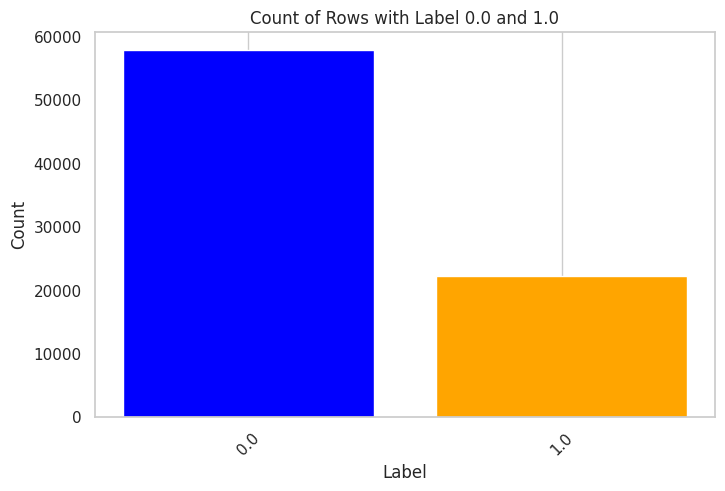

In [370]:
label_counts = df.groupBy("label").count().toPandas()

plt.figure(figsize=(8, 5))
plt.bar(label_counts['label'].astype(str), label_counts['count'], color=['blue', 'orange'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Rows with Label 0.0 and 1.0')
plt.xticks(rotation=45)
plt.grid(axis='y')

Из графика можно сдлеать вывод, что в данных наблюдается дисбаланс классов, что может повлиять на качество модели

In [4]:
df = df.fillna(0)
test_df = test_df.fillna(0)

# Построение и проверка гипотез

Далее будут выбираться новыми параметры, с каждым параметром будут проверятся гипотезы:  

H0: ROC-AUC модели с новым признаком не будет выше, чем ROC-AUC модели без нового признака.  
H1: ROC-AUC модели с новым признаком будет выше, чем ROC-AUC модели без нового признака.  

По правильному, нужно было бы рассчитывать p_value и выбирать уровень значимости, а затем решать какую гипотезу принимать. но для раcсчета p_value нужно больше чем 1 запуск без признака и 1 запускc признаком. В этой работе я буду расматривать 7 групп признаков и запускать обучение для каждой группы еще и по n раз для рассчета p-value кажется мне лишним.  
Для упрощения, буду считать, что если ROC-AUC модели с новым признаком больше хотся бы на 0.01 ROC-AUC модели без признака, то я буду отвергать гипотезу H0 в пользу H1.

# Статистики по values

In [5]:
def array_mean(values):
    filtered_values = [v for v in values if v is not None]
    if len(filtered_values) == 0:
        return None
    return sum(filtered_values) / len(filtered_values)

def median(values):
    values = [v for v in values if v is not None]
    sorted_values = sorted(values)
    n = len(sorted_values)
    mid = n // 2
    return (sorted_values[mid] if n % 2 != 0 else (sorted_values[mid - 1] + sorted_values[mid]) / 2) if values else None

array_mean = F.udf(array_mean, FloatType())
median_udf = F.udf(median, FloatType())

In [407]:
stats_df = df.withColumn("mean_value", array_mean("values")) \
       .withColumn("stddev_value", F.expr("sqrt(aggregate(values, 0D, (acc, x) -> acc + pow(x - mean_value, 2)) / size(values))")) \
       .withColumn("min_value", F.array_min("values")) \
       .withColumn("max_value", F.array_max("values")) \
       .withColumn("median_value", median_udf("values"))

### EDA

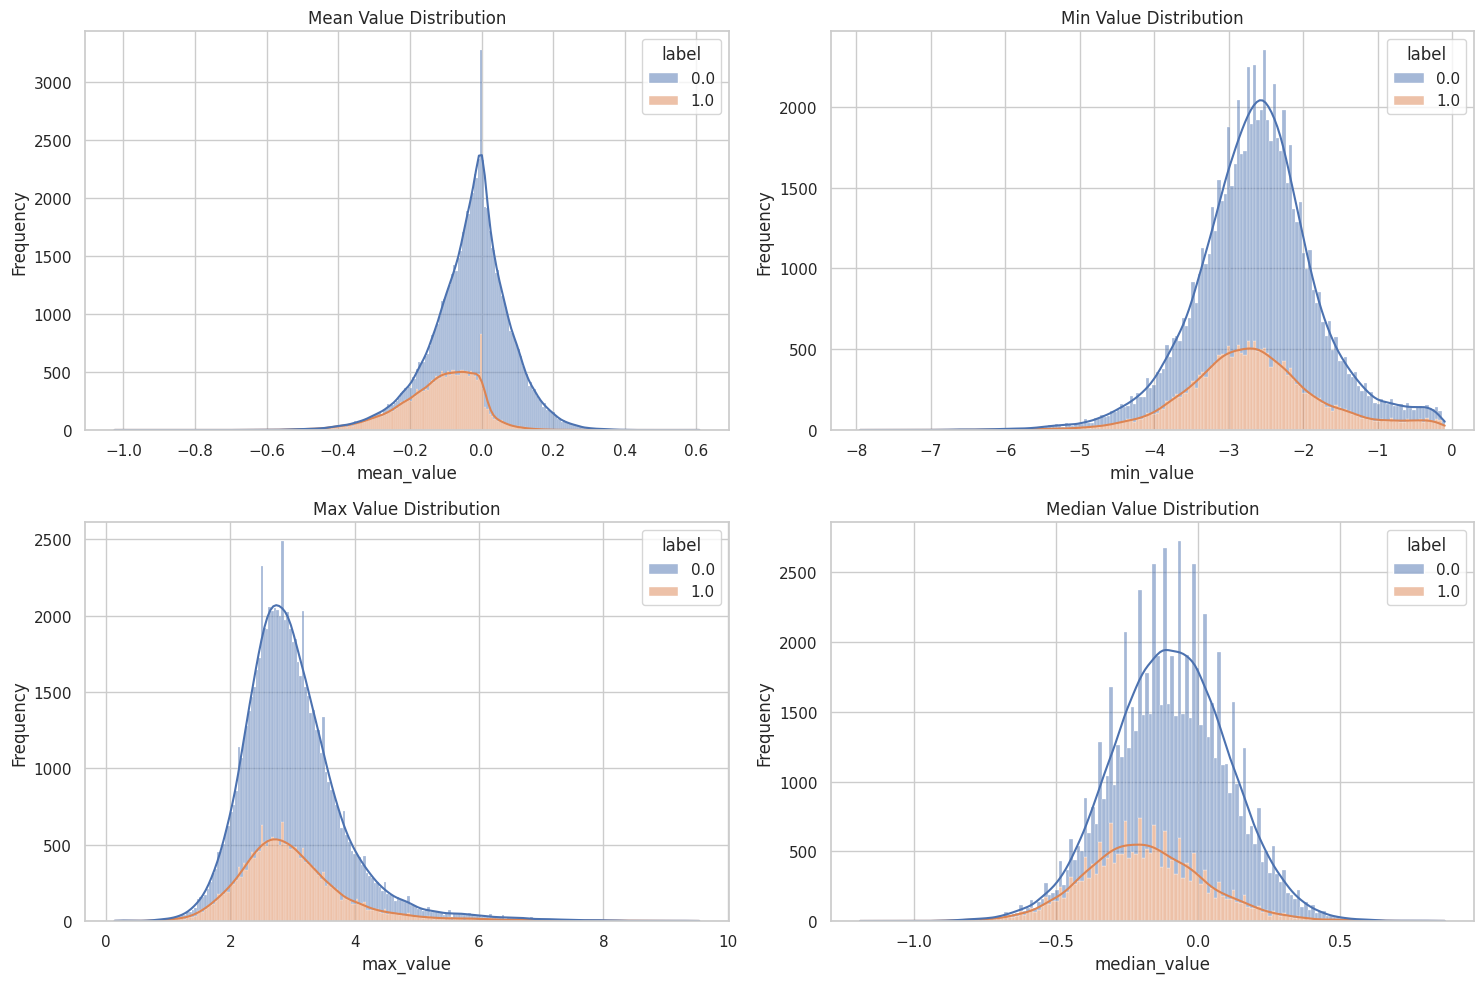

In [352]:
pandas_df = stats_df.select("label", "mean_value", "min_value", "max_value", "median_value").toPandas()

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axes = axes.flatten()

columns_to_plot = ["mean_value", "min_value", "max_value", "median_value"]
titles = ["Mean Value Distribution", "Min Value Distribution", "Max Value Distribution", "Median Value Distribution"]

for ax, col, title in zip(axes, columns_to_plot, titles):
    sns.histplot(data=pandas_df, x=col, hue="label", multiple="stack", ax=ax, kde=True)
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Если держать в голове, что у нас изначально наблюдается дисбаланс классов, то нужно смотреть на график распредления. У максимальных и минимальных занчений графики распредлений почти один в один, у медиан график при 1 классе чуть смещен, у среднего график при классе 1 вообще имеет другой вид. В целом по графикам можно сделать вывод, что проверить зависимость между статистиками и label не лишено смысла, особенно для средних и медианных значений

### Проверка гипотезы

Чтобы оценить эффект от добавления новых параметров, надо прогнать модель с ними и без них и зафиксировать ROC-AUC в обоих случаях а потом сравнить. Проблема, что на данном этапе у нас нет других признаков, поэтому проверим гипотзу по важности статистик по значениям в самом конце, когда уже будет пулл других признаков.

In [408]:
stats_df = stats_df.fillna(0)
vector_assembler = VectorAssembler(inputCols=["mean_value",
                                              "stddev_value",
                                              "min_value",
                                              "max_value",
                                              "median_value"
                                              ], outputCol="features")

stats_df = vector_assembler.transform(stats_df)

In [409]:
train_stats_df, val_stats_df = stats_df.randomSplit([0.75, 0.15], seed=42)

In [410]:
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100)
model = gbt.fit(train_stats_df)

predictions = model.transform(val_stats_df)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")

roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC with values's statistics: {roc_auc}")

ROC-AUC with values's statistics: 0.6929100480553176


# Лаги

lag1 - последнее значение из массива values  
lag2 - предпоследнее значение из массива values  

In [398]:
stats_df = df.withColumn("mean_value", array_mean("values")) \
       .withColumn("stddev_value", F.expr("sqrt(aggregate(values, 0D, (acc, x) -> acc + pow(x - mean_value, 2)) / size(values))")) \
       .withColumn("min_value", F.array_min("values")) \
       .withColumn("max_value", F.array_max("values")) \
       .withColumn("median_value", median_udf("values")) \
       .withColumn("lag1", F.expr("values[size(values) - 1]")) \
       .withColumn("lag2", F.expr("values[size(values) - 2]"))

### EDA

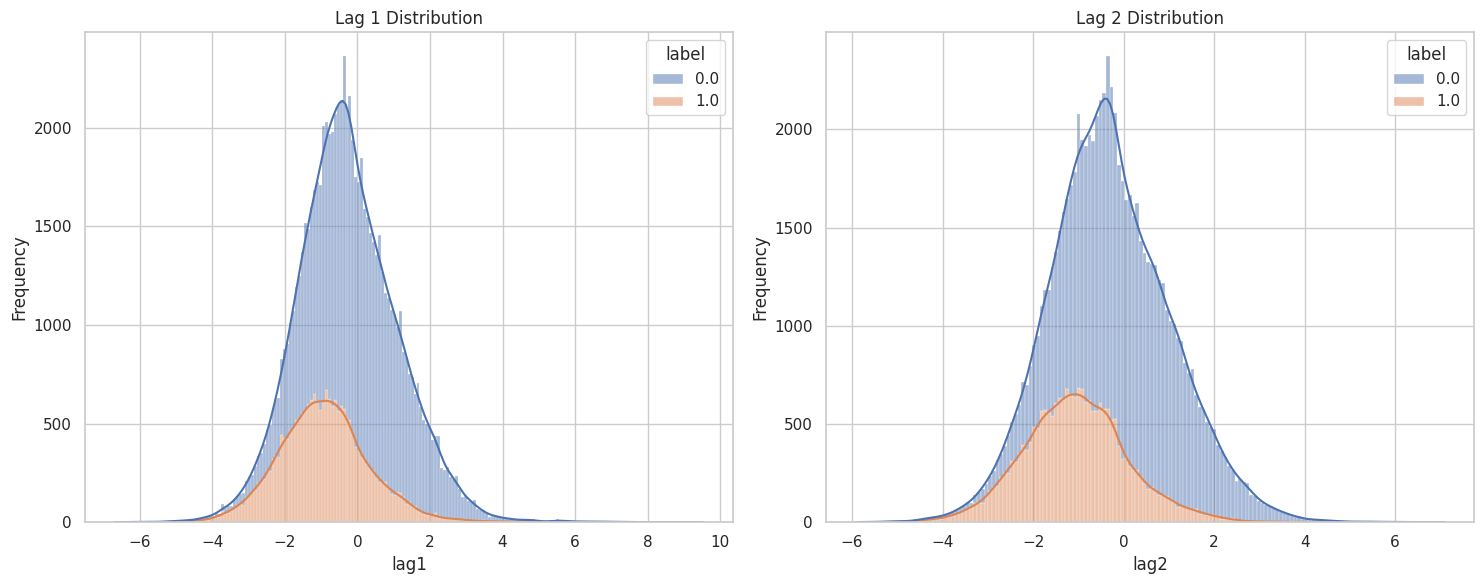

In [354]:
pandas_df = stats_df.select("label", "lag1", "lag2").toPandas()

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

columns_to_plot = ["lag1", "lag2"]
titles = ["Lag 1 Distribution", "Lag 2 Distribution"]

for ax, col, title in zip(axes, columns_to_plot, titles):
    sns.histplot(data=pandas_df, x=col, hue="label", multiple="stack", ax=ax, kde=True)
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

У lag1 графики для 1 и 0 класса похожт, у lag2 уже менее похожи.

### Проверка гипотезы

In [399]:
stats_df = stats_df.fillna(0)
vector_assembler = VectorAssembler(inputCols=["mean_value",
                                              "stddev_value",
                                              "min_value",
                                              "max_value",
                                              "median_value",
                                              "lag1",
                                              "lag2"
                                              ], outputCol="features")

stats_df = vector_assembler.transform(stats_df)

In [400]:
train_stats_df, val_stats_df = stats_df.randomSplit([0.75, 0.15], seed=42)

In [401]:
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100)
model = gbt.fit(train_stats_df)

predictions = model.transform(val_stats_df)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")

roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC with lag1 and lag2: {roc_auc}")

ROC-AUC with lag1 and lag2: 0.7546831030435731


Вывод: увеличение ROC-AUC на 0.06 => Эффект от добавления лагов есть => принимаем гипотезу H1

# Скользящее среднее

In [6]:
def moving_average(values, window_size=5):
    values = [v for v in values if v is not None]
    if len(values) < window_size:
        return None
    return sum(values[-window_size:]) / window_size

moving_average_udf = F.udf(moving_average, FloatType())

In [411]:
stats_df = df.withColumn("mean_value", array_mean("values")) \
       .withColumn("stddev_value", F.expr("sqrt(aggregate(values, 0D, (acc, x) -> acc + pow(x - mean_value, 2)) / size(values))")) \
       .withColumn("min_value", F.array_min("values")) \
       .withColumn("max_value", F.array_max("values")) \
       .withColumn("median_value", median_udf("values")) \
       .withColumn("lag1", F.expr("values[size(values) - 1]")) \
       .withColumn("lag2", F.expr("values[size(values) - 2]")) \
       .withColumn("moving_average", moving_average_udf("values"))

### EDA

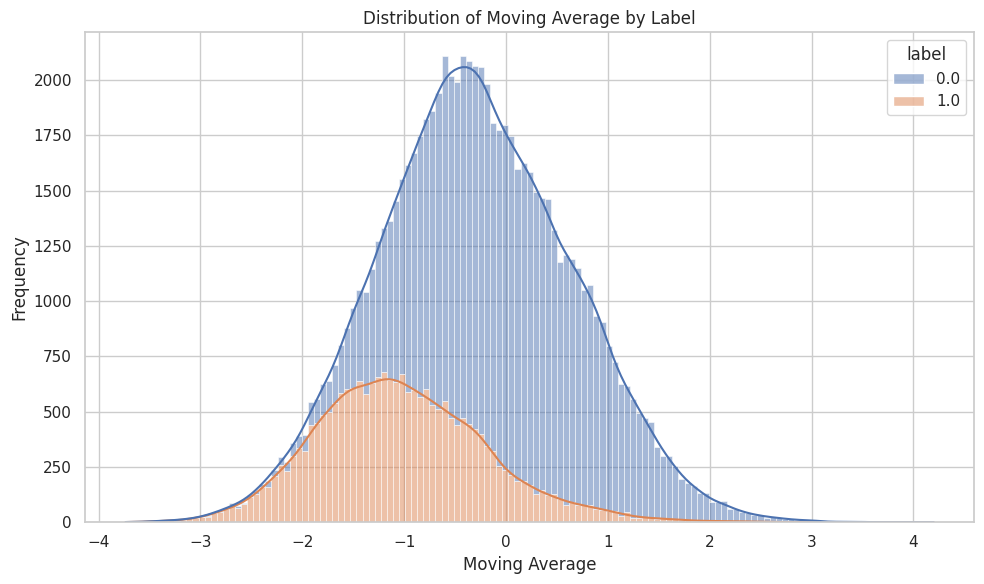

In [356]:
pandas_df = stats_df.select("label", "moving_average").toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(data=pandas_df, x="moving_average", hue="label", multiple="stack", kde=True)

plt.title("Distribution of Moving Average by Label")
plt.xlabel("Moving Average")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Распредление сильно зависит от класса => можно преполагать улучшение ROC-AUC при добавлении скользящего среднего

### Проверка гипотезы

In [412]:
stats_df = stats_df.fillna(0)
vector_assembler = VectorAssembler(inputCols=["mean_value",
                                              "stddev_value",
                                              "min_value",
                                              "max_value",
                                              "median_value",
                                              "lag1",
                                              "lag2",
                                              "moving_average"
                                              ], outputCol="features")

stats_df = vector_assembler.transform(stats_df)

In [413]:
train_stats_df, val_stats_df = stats_df.randomSplit([0.75, 0.15], seed=42)

In [414]:
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100)
model = gbt.fit(train_stats_df)

predictions = model.transform(val_stats_df)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")

roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC with moving average: {roc_auc}")

ROC-AUC with moving average: 0.7892779176877999


Вывод: увеличение ROC-AUC на 0.03 => эффект от добавления смещенного среднего есть => принимаем гипотезу H1

# Данные по датам

count_dates - количество дат в массиве с датами из столбца dates  
date_diff - разница в днях между первой и последней датой из массиве с датами из столбца dates

In [367]:
stats_df = df.withColumn("mean_value", array_mean("values")) \
       .withColumn("stddev_value", F.expr("sqrt(aggregate(values, 0D, (acc, x) -> acc + pow(x - mean_value, 2)) / size(values))")) \
       .withColumn("min_value", F.array_min("values")) \
       .withColumn("max_value", F.array_max("values")) \
       .withColumn("median_value", median_udf("values")) \
       .withColumn("lag1", F.expr("values[size(values) - 1]")) \
       .withColumn("lag2", F.expr("values[size(values) - 2]")) \
       .withColumn("moving_average", moving_average_udf("values")) \
       .withColumn("count_dates", F.size("dates")) \
       .withColumn("date_diff",
                   F.datediff(
                       F.to_date(F.array_max("dates"), "yyyy-MM-dd"),
                       F.to_date(F.array_min("dates"), "yyyy-MM-dd")
                   ))

### EDA

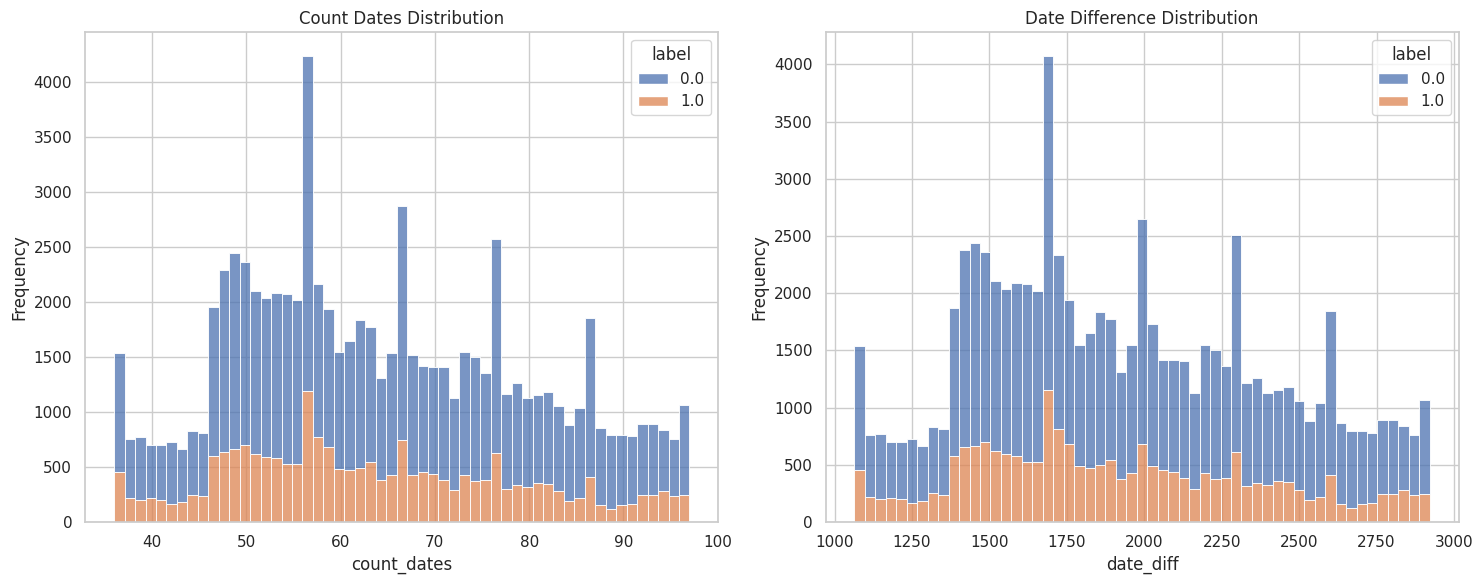

In [368]:
pandas_df = stats_df.select("label", "count_dates", "date_diff").toPandas()

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

columns_to_plot = ["count_dates", "date_diff"]
titles = ["Count Dates Distribution", "Date Difference Distribution"]

for ax, col, title in zip(axes, columns_to_plot, titles):
    sns.histplot(data=pandas_df, x=col, hue="label", multiple="stack", ax=ax)
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

По ощущениям разница между графиками для класса 1 и 0 минимальна. Даже если их добавить в парметры, эффекта вау не будет, но проверим. Графики  для count dates и date diff получились одинаковыми, что навевает очевидную мысль что count_dates и date_diff имеют прямую зависимость. Вероятнее всего добавлять оба признака одновременно не имеет смысла

### Проверка гипотезы

In [314]:
stats_df = stats_df.fillna(0)
vector_assembler = VectorAssembler(inputCols=["mean_value",
                                              "stddev_value",
                                              "min_value",
                                              "max_value",
                                              "median_value",
                                              "lag1",
                                              "lag2",
                                              "moving_average",
                                              "count_dates",
                                              "date_diff"
                                              ], outputCol="features")

stats_df = vector_assembler.transform(stats_df)

In [315]:
train_stats_df, val_stats_df = stats_df.randomSplit([0.75, 0.15], seed=42)

In [316]:
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100)
model = gbt.fit(train_stats_df)

predictions = model.transform(val_stats_df)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")

roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC with dates' statistics: {roc_auc}")

ROC-AUC with dates' statistics: 0.7918692808667039


Вывод: увеличение ROC-AUC на 0.01 => эффект от добавления статистик по датам есть => принимаем гипотезу H1

# Сезонность

Winter - количество зимних дат из массива   
Spring - количество весенних дат из массива     
Summer - количество летних дат из массива    
Autumn - количество осенних дат из массива    


In [371]:
stats_df = df.withColumn("mean_value", array_mean("values")) \
       .withColumn("stddev_value", F.expr("sqrt(aggregate(values, 0D, (acc, x) -> acc + pow(x - mean_value, 2)) / size(values))")) \
       .withColumn("min_value", F.array_min("values")) \
       .withColumn("max_value", F.array_max("values")) \
       .withColumn("median_value", median_udf("values")) \
       .withColumn("lag1", F.expr("values[size(values) - 1]")) \
       .withColumn("lag2", F.expr("values[size(values) - 2]")) \
       .withColumn("moving_average", moving_average_udf("values")) \
       .withColumn("count_dates", F.size("dates")) \
       .withColumn("date_diff",
                   F.datediff(
                       F.to_date(F.array_max("dates"), "yyyy-MM-dd"),
                       F.to_date(F.array_min("dates"), "yyyy-MM-dd")
                   )) \
       .withColumn("Winter", F.size(F.expr("filter(dates, d -> month(to_date(d)) in (12, 1, 2))"))) \
       .withColumn("Spring", F.size(F.expr("filter(dates, d -> month(to_date(d)) in (3, 4, 5))"))) \
       .withColumn("Summer", F.size(F.expr("filter(dates, d -> month(to_date(d)) in (6, 7, 8))"))) \
       .withColumn("Autumn", F.size(F.expr("filter(dates, d -> month(to_date(d)) in (9, 10, 11))")))

### EDA

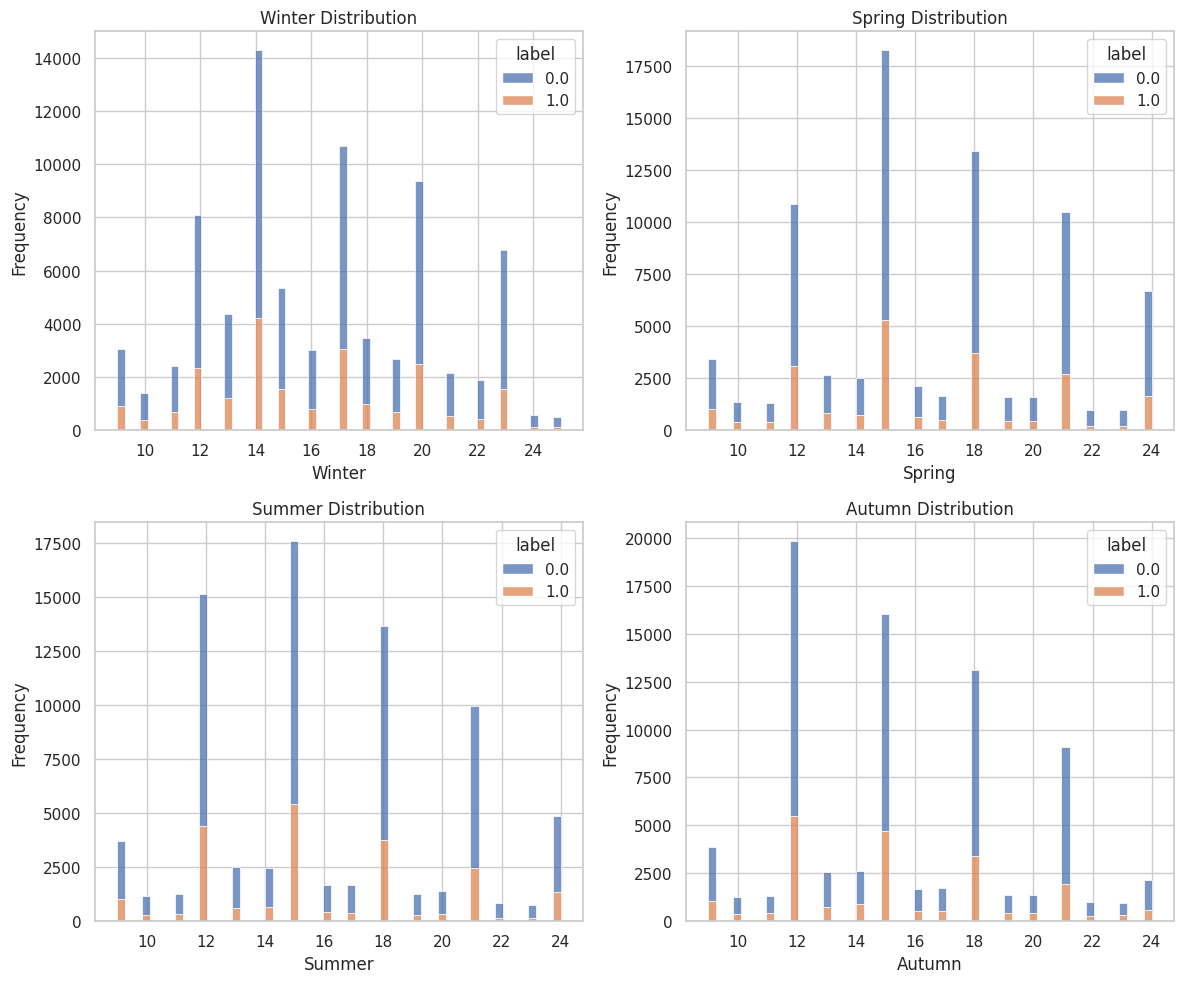

In [372]:
pandas_df = stats_df.select("label", "Winter", "Spring", "Summer", "Autumn").toPandas()

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

season_columns = ["Winter", "Spring", "Summer", "Autumn"]
titles = ["Winter Distribution", "Spring Distribution", "Summer Distribution", "Autumn Distribution"]

axes = axes.flatten()

for ax, col, title in zip(axes, season_columns, titles):
    sns.histplot(data=pandas_df, x=col, hue="label", multiple="stack", ax=ax)
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

В целом графики выглядят одинаково вне зависимости от класса, если учесть изначальный дисбаланс классов. Веротянее сезонность будет слабо влиять

### Проверка гипотезы

In [319]:
stats_df = stats_df.fillna(0)
vector_assembler = VectorAssembler(inputCols=["mean_value",
                                              "stddev_value",
                                              "min_value",
                                              "max_value",
                                              "median_value",
                                              "lag1",
                                              "lag2",
                                              "moving_average",
                                              "count_dates",
                                              "date_diff",
                                              "Winter",
                                              "Spring",
                                              "Summer",
                                              "Autumn"
                                              ], outputCol="features")

stats_df = vector_assembler.transform(stats_df)

In [320]:
train_stats_df, val_stats_df = stats_df.randomSplit([0.75, 0.15], seed=42)

In [321]:
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100)
model = gbt.fit(train_stats_df)

predictions = model.transform(val_stats_df)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")

roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC with seasons: {roc_auc}")

ROC-AUC with seasons: 0.7927778594198437


Вывод: увличение ROC-AUC менее чем на 0.01 => эффект от добавления сезонов минимальный => зависимость между сезонностью и label минимальна => принимаем гипотезу H0

# Разности между соседними значениями во временном ряде

first_diff - разности между соседними значениями во временном ряде  
mean_diff - среднее значение разностей  
stddev_diff- стандартное отклонение разностей  

In [7]:
def first_diff(values):
    filtered_values = [v for v in values if v is not None]
    # Вычисляем разности
    return [filtered_values[i] - filtered_values[i - 1] for i in range(1, len(filtered_values))] if len(filtered_values) > 1 else []

def mean_diff(differences):
    return sum(differences) / len(differences) if len(differences) > 0 else None

def stddev_diff(differences):
    if len(differences) == 0:
        return None
    mean = sum(differences) / len(differences)
    return (sum((x - mean) ** 2 for x in differences) / len(differences)) ** 0.5

first_diff = F.udf(first_diff, ArrayType(FloatType()))
mean_diff = F.udf(mean_diff, FloatType())
stddev_diff = F.udf(stddev_diff, FloatType())

In [428]:
stats_df = df.withColumn("mean_value", array_mean("values")) \
       .withColumn("stddev_value", F.expr("sqrt(aggregate(values, 0D, (acc, x) -> acc + pow(x - mean_value, 2)) / size(values))")) \
       .withColumn("min_value", F.array_min("values")) \
       .withColumn("max_value", F.array_max("values")) \
       .withColumn("median_value", median_udf("values")) \
       .withColumn("lag1", F.expr("values[size(values) - 1]")) \
       .withColumn("lag2", F.expr("values[size(values) - 2]")) \
       .withColumn("moving_average", moving_average_udf("values")) \
       .withColumn("count_dates", F.size("dates")) \
       .withColumn("date_diff",
                   F.datediff(
                       F.to_date(F.array_max("dates"), "yyyy-MM-dd"),
                       F.to_date(F.array_min("dates"), "yyyy-MM-dd")
                   )) \
       .withColumn("first_diff", first_diff("values")) \
       .withColumn("mean_diff", mean_diff("first_diff")) \
       .withColumn("stddev_diff", stddev_diff("first_diff"))

### EDA

In [416]:
pandas_df = stats_df.select("label", "mean_diff", "stddev_diff").toPandas()

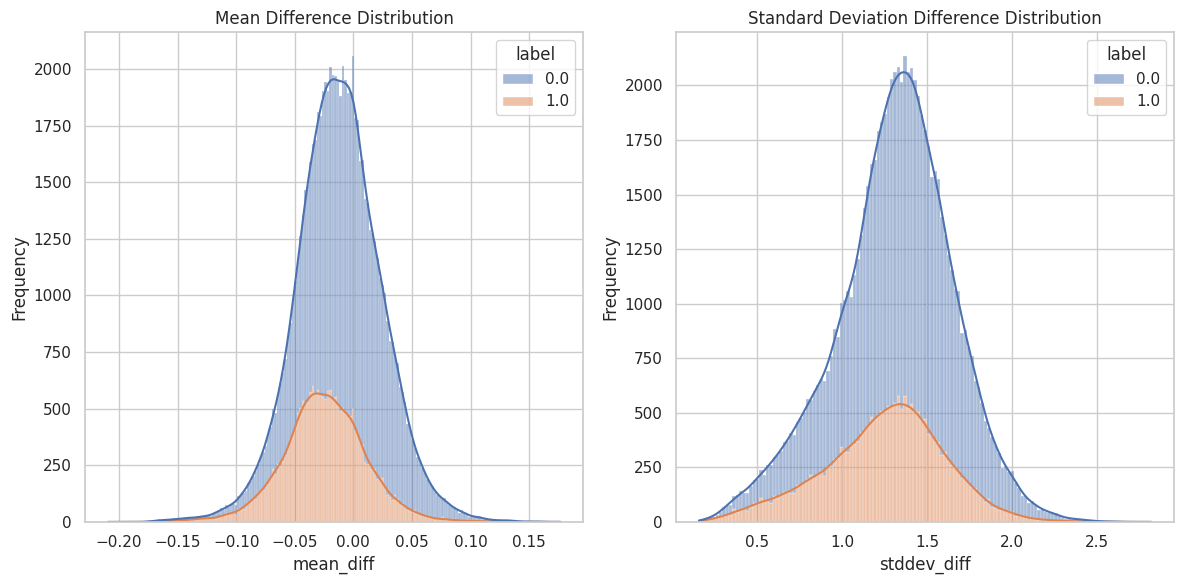

In [417]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

diff_columns = ["mean_diff", "stddev_diff"]
titles = ["Mean Difference Distribution", "Standard Deviation Difference Distribution"]

for ax, col, title in zip(axes, diff_columns, titles):
    sns.histplot(data=pandas_df, x=col, hue="label", multiple="stack", kde=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Графики при разных классах похожи, если зависимость с label есть, то не большая

### Проверка гипотезы

In [429]:
stats_df = stats_df.fillna(0)
vector_assembler = VectorAssembler(inputCols=["mean_value",
                                              "stddev_value",
                                              "min_value",
                                              "max_value",
                                              "median_value",
                                              "lag1",
                                              "lag2",
                                              "moving_average",
                                              "count_dates",
                                              "date_diff",
                                              "mean_diff",
                                              "stddev_diff"
                                              ], outputCol="features")

stats_df = vector_assembler.transform(stats_df)

In [430]:
train_stats_df, val_stats_df = stats_df.randomSplit([0.75, 0.15], seed=42)

In [431]:
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100)
model = gbt.fit(train_stats_df)

predictions = model.transform(val_stats_df)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")

roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC with first_diff: {roc_auc}")

ROC-AUC with first_diff: 0.8000015732485694


Вывод: увеличение ROC-AUC на 0.01 => эффект от добавления  есть => принимаем гипотезу H1

# Проверка гипотезы о важности статистик по значениям

Вспомним, что у нас остался не оценен вклад "mean_value", "stddev_value","min_value", "max_value", "median_value". Поэтому протестируем модель без них и зафиксируем, упадет ли ROC-AUC и на сколько

In [422]:
stats_df = df.withColumn("lag1", F.expr("values[size(values) - 1]")) \
       .withColumn("lag2", F.expr("values[size(values) - 2]")) \
       .withColumn("moving_average", moving_average_udf("values")) \
       .withColumn("count_dates", F.size("dates")) \
       .withColumn("date_diff",
                   F.datediff(
                       F.to_date(F.array_max("dates"), "yyyy-MM-dd"),
                       F.to_date(F.array_min("dates"), "yyyy-MM-dd")
                   )) \
       .withColumn("first_diff", first_diff("values")) \
       .withColumn("mean_diff", mean_diff("first_diff")) \
       .withColumn("stddev_diff", stddev_diff("first_diff"))

In [423]:
stats_df = stats_df.fillna(0)
vector_assembler = VectorAssembler(inputCols=["lag1",
                                              "lag2",
                                              "moving_average",
                                              "count_dates",
                                              "date_diff",
                                              "mean_diff",
                                              "stddev_diff"
                                              ], outputCol="features")

stats_df = vector_assembler.transform(stats_df)

In [426]:
train_stats_df, val_stats_df = stats_df.randomSplit([0.75, 0.15], seed=42)

In [427]:
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100)
model = gbt.fit(train_stats_df)

predictions = model.transform(val_stats_df)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")

roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC without values' statisctics: {roc_auc}")

ROC-AUC without values' statisctics: 0.6912636929353245


Вывод: падение ROC-AUC с 0.80 до 0.69 => статистики по values сильно влияют на решение модели => принимает гипотезу H1

# Запуск на тесте

In [19]:
stats_df = df.withColumn("mean_value", array_mean("values")) \
       .withColumn("stddev_value", F.expr("sqrt(aggregate(values, 0D, (acc, x) -> acc + pow(x - mean_value, 2)) / size(values))")) \
       .withColumn("min_value", F.array_min("values")) \
       .withColumn("max_value", F.array_max("values")) \
       .withColumn("median_value", median_udf("values")) \
       .withColumn("lag1", F.expr("values[size(values) - 1]")) \
       .withColumn("lag2", F.expr("values[size(values) - 2]")) \
       .withColumn("moving_average", moving_average_udf("values")) \
       .withColumn("count_dates", F.size("dates")) \
       .withColumn("date_diff",
                   F.datediff(
                       F.to_date(F.array_max("dates"), "yyyy-MM-dd"),
                       F.to_date(F.array_min("dates"), "yyyy-MM-dd")
                   )) \
       .withColumn("first_diff", first_diff("values")) \
       .withColumn("mean_diff", mean_diff("first_diff")) \
       .withColumn("stddev_diff", stddev_diff("first_diff"))

In [20]:
stats_test_df = test_df.withColumn("mean_value", array_mean("values")) \
       .withColumn("stddev_value", F.expr("sqrt(aggregate(values, 0D, (acc, x) -> acc + pow(x - mean_value, 2)) / size(values))")) \
       .withColumn("min_value", F.array_min("values")) \
       .withColumn("max_value", F.array_max("values")) \
       .withColumn("median_value", median_udf("values")) \
       .withColumn("lag1", F.expr("values[size(values) - 1]")) \
       .withColumn("lag2", F.expr("values[size(values) - 2]")) \
       .withColumn("moving_average", moving_average_udf("values")) \
       .withColumn("count_dates", F.size("dates")) \
       .withColumn("date_diff",
                   F.datediff(
                       F.to_date(F.array_max("dates"), "yyyy-MM-dd"),
                       F.to_date(F.array_min("dates"), "yyyy-MM-dd")
                   )) \
       .withColumn("first_diff", first_diff("values")) \
       .withColumn("mean_diff", mean_diff("first_diff")) \
       .withColumn("stddev_diff", stddev_diff("first_diff"))

In [21]:
stats_df = stats_df.fillna(0)
stats_test_df = stats_test_df.fillna(0)
vector_assembler = VectorAssembler(inputCols=["mean_value",
                                              "stddev_value",
                                              "min_value",
                                              "max_value",
                                              "median_value",
                                              "lag1",
                                              "lag2",
                                              "moving_average",
                                              "count_dates",
                                              "date_diff",
                                              "mean_diff",
                                              "stddev_diff"
                                              ], outputCol="features")

stats_df = vector_assembler.transform(stats_df)
stats_test_df = vector_assembler.transform(stats_test_df)

In [22]:
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100)
model = gbt.fit(stats_df)

In [23]:
predictions = model.transform(stats_test_df)

# Сохранение модели и результатов

In [13]:
model.save("/content/model")

In [ ]:
import shutil
from google.colab import files

shutil.make_archive('model', 'zip', '/content/model')

files.download('model.zip')

### Получение нужного формата для сохранения результатов

In [24]:
def vector_to_array(v):
    return v.toArray().tolist() if v is not None else None

vector_to_array_udf = udf(vector_to_array, ArrayType(FloatType()))

predictions = predictions.withColumn("probability_array", vector_to_array_udf(col("probability")))
predictions = predictions.withColumn("score", col("probability_array").getItem(1))
answer_df = predictions.select("id", "score")
answer_df.show()

+-----+-----------+
|   id|      score|
+-----+-----------+
| 6125|  0.1321214|
|26781| 0.08898953|
|13333|  0.4680012|
|53218|0.026135966|
|84204| 0.33392382|
|69997|  0.7856886|
|99301|  0.9422647|
| 4361| 0.90713954|
|46607| 0.16508186|
|29836|  0.5854949|
|59154|0.035277657|
|80632|  0.8092701|
|33723| 0.06686582|
|  663| 0.04800655|
|  764|0.101208024|
|11059| 0.87399036|
| 5358|0.023375642|
|92154|  0.7972783|
|73744|  0.5476228|
|62536| 0.48465627|
+-----+-----------+
only showing top 20 rows



In [36]:
answer_df.toPandas().to_csv('/content/submission.csv')